In [ ]:
import base64
from docx2pdf import convert
from mistralai import Mistral
import os
import pandas as pd
import pickle
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

os.environ["MISTRAL_API_KEY"] = ''
RANDOM_STATE = 42

c:\Users\alexysxeightn\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('df_clear_uniq_3.csv')
df

,part_num,manufacturer,TNVED,concat_str,path_ds,id_path
0,XC7K410T-2FFG900I,XILINX,8542399010,XC7K410T-2FFG900I XILINX,M:\DataSheet\d76e3861-23b6-11ed-96e5-f8bc12505...,d76e3861-23b6-11ed-96e5-f8bc12505841
1,NC7WZ04P6X,ON SEMICONDUCTOR,8542399010,NC7WZ04P6X ON SEMICONDUCTOR,M:\DataSheet\b09bd526-4a32-11ed-96e6-f8bc12505...,b09bd526-4a32-11ed-96e6-f8bc12505841
2,ADUM1401ARWZ,ANALOG DEVICES,8542399010,ADUM1401ARWZ ANALOG DEVICES,M:\DataSheet\2ff0bfb5-6804-11ee-96f4-f8bc12505...,2ff0bfb5-6804-11ee-96f4-f8bc12505841
3,GCM155R71C104KA55D,MURATA ELECTRONICS,8532240000,GCM155R71C104KA55D MURATA ELECTRONICS,M:\DataSheet\8436bcbb-4a18-11ed-96e6-f8bc12505...,8436bcbb-4a18-11ed-96e6-f8bc12505841
4,ADA4898-1YRDZ,ANALOG DEVICES,8542339000,ADA4898-1YRDZ ANALOG DEVICES,M:\DataSheet\cb8a2892-ddc2-11ed-96f0-f8bc12505...,cb8a2892-ddc2-11ed-96f0-f8bc12505841
...,...,...,...,...,...,...
12341,VT3-801FL,QUARTZCOM AG,8542393000,VT3-801FL QUARTZCOM AG,M:\DataSheet\c005ef03-1ecc-11ed-96e5-f8bc12505...,c005ef03-1ecc-11ed-96e5-f8bc12505841
12342,FD129225UB-Q-EAG(2FE)-RUM,YEN SUN TECHNOLOGY CORP.,8414592000,FD129225UB-Q-EAG(2FE)-RUM YEN SUN TECHNOLOGY C...,M:\DataSheet\971e123f-c542-11ec-96e1-f8bc12505...,971e123f-c542-11ec-96e1-f8bc12505841
12343,BC817-16,YANGZHOU YANGJIE ELECTRONIC,8541210000,BC817-16 YANGZHOU YANGJIE ELECTRONIC,M:\DataSheet\a5bde0c0-c8af-11ed-96ee-f8bc12505...,a5bde0c0-c8af-11ed-96ee-f8bc12505841
12344,2J2004B-B05H-500RG58-C91NST_MARU,2J,8517711900,2J2004B-B05H-500RG58-C91NST_MARU 2J,M:\DataSheet\eceb9dfd-e6fb-11ec-96e1-f8bc12505...,eceb9dfd-e6fb-11ec-96e1-f8bc12505841


In [2]:
len(df['TNVED']), len(set(df['TNVED']))

(12346, 87)

Т.к. у нас по факту у нас всего 87 уникальных кодов, то можно решить задачу как задачу классификации

<Axes: >

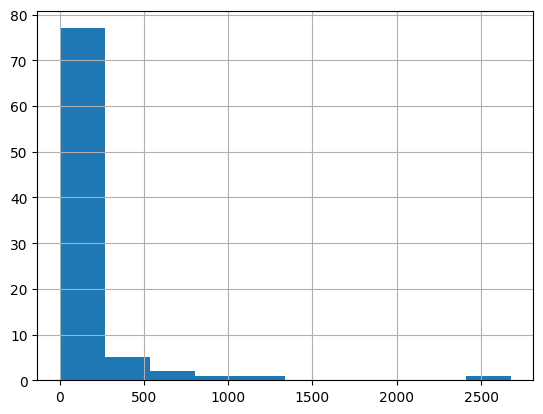

In [5]:
df.groupby('TNVED')['part_num'].count().hist()

Виден четкий дисбаланс классов

In [6]:
df.groupby('TNVED')['part_num'].count().sort_values()

TNVED
8486400009       2
7318155900       7
7326909807       7
8525891900       8
8544429009       9
              ... 
8541100009     662
8532240000     742
8533100000     926
8536693000    1107
8542399010    2676
Name: part_num, Length: 87, dtype: int64

Разделим выборку на тестовую и обучающую, стратифицирую по коду TNVED (чтобы распределения в обучении и тесте были похожи на рельное распределение кодов)

In [ ]:
X = df.drop(['TNVED'], axis=1)
y = df['TNVED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

## Бейзлайн: предсказываем всем самый популярный код

In [14]:
y_pred = pd.Series([y_train.mode().iloc[0]] * len(X_test))

In [15]:
print('accuracy', accuracy_score(y_test, y_pred))
print('f1-macro', f1_score(y_test, y_pred, average='macro'))
print('f1-micro', f1_score(y_test, y_pred, average='micro'))
print('f1-weighted', f1_score(y_test, y_pred, average='weighted'))

accuracy 0.2165991902834008
f1-macro 0.004140386178075301
f1-micro 0.2165991902834008
f1-weighted 0.07712516925232575


Кажется, что самая валидная метрика для данной задачи это `f1-weighted`, т.к. у нас много классов и они имеют разный размер. Данная метрика позволит каждому классу внести равный вклад в метрику. Для бейзлайна она равна 8%

## Используем файлы

В `datasheets_miro` часть pdf-файлов бита (0 Кб) и часть файлов закрыты паролем. Их невозможно использовать для обучения и тестирования, поэтому лучше их убрать из анализа

Также есть часть docx-файлов, png-файлов и jpg-файлов.

К тому же иногда в файле нет валидной информации про необходимый элемент (однако LLM иногда сама знает характеристики этого элемента)

Можно поступить следующим образом:
- переконвертировать docx-файлы в pdf
- вытащить информацию из pdf-файлов и изображений с помощью mistral ocr
- сделать summary с помощью mistral llm

Для сокращения вычислений не будем проводить процедуру для документов, которые уже есть в `datasheets_miro_gpt4o_mini`

После получения всех summary можно получить эмбеддинги для них (с помощью любой предобученной модели) и обучить на нем классификатор (например, xgboost)

In [23]:
# Функция для проверки PDF-файла на битость или пароль
def is_pdf_valid(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        if reader.is_encrypted:
            return False  # Защищен паролем
        return True  # Файл валидный
    except Exception:
        return False  # Битый файл


system_prompt = """
    You are a technical specialist with expertise in electronics. Your task is to analyze datasheets for electronic components and provide a concise summary of the product’s key characteristics and specifications. In addition, you need to gather textual information about the component, including its description and typical applications.Instructions:    Identify the correct component in the datasheet using the provided product code.    Summarize key parameters, including:        Voltage ratings        Current ratings        Power consumption        Operating temperature range        Package type        Special features or notes (if applicable)        Moisture Sensetive Level JEDEC J-STD-020E    Provide a short description of the component, including what it is (e.g., transistor, microcontroller, sensor) and its primary function.    Explain typical applications for the component (e.g., power management, signal processing, data storage, etc.).    Be thorough and accurate: Ensure the information corresponds specifically to the product code, as some datasheets cover multiple variants.Your goal is to create a clear and accurate technical summary that includes both key specifications and a description of what the component is used for.
"""

client = Mistral(api_key=os.environ["MISTRAL_API_KEY"])

pdfs_path     = "datasheets_miro"
complete_path = "datasheets_miro_gpt4o_mini"
summary_path  = "datasheets_miro_llm"

rows_to_drop = []

for index, row in df.iterrows():
    filename = row["id_path"]
    docx_path = os.path.join(pdfs_path, f"{filename}.docx")
    pdf_path = os.path.join(pdfs_path, f"{filename}.pdf")
    image_paths = [
        os.path.join(pdfs_path, f"{filename}.png"),
        os.path.join(pdfs_path, f"{filename}.jpeg"),
    ]

    # Если есть .docx файл, конвертировать его в PDF
    if os.path.exists(docx_path):
        output_pdf_path = os.path.join(pdfs_path, f"{filename}.pdf")
        convert(docx_path, output_pdf_path)

    # Если есть валидный .pdf файл, провести OCR и сделать summary
    if os.path.exists(pdf_path):
        if is_pdf_valid(pdf_path):
            if not os.path.exists(os.path.join(complete_path, f"{filename}.txt")):
                with open(os.path.join(pdfs_path, f"{filename}.pdf"), "rb") as f:
                    uploaded_pdf = client.files.upload(
                        file={
                            "file_name": os.path.join(pdfs_path, f"{filename}.pdf"),
                            "content": f.read(4 * 131072), # Обрезка pdf-файла (некоторые pdf слишком большие и не влазят в промпт, основная информация все равно скорее всего находится в начале документа)
                        },
                        purpose="ocr",
                    )
                chat_response = client.chat.complete(
                    model="mistral-large-latest",
                    messages=[
                        {
                            "role": "system",
                            "content": system_prompt,
                        },
                        {
                            "role": "user",
                            "content": [
                                {
                                    "type": "text",
                                    "text": f"Give me information about the component of {row["part_num"]} production of {row["manufacturer"]} from the text:",
                                },
                                {
                                    "type": "document_url",
                                    "document_url": client.files.get_signed_url(
                                        file_id=uploaded_pdf.id
                                    ).url,
                                },
                            ],
                        },
                    ],
                )
                result = chat_response.choices[0].message.content
                with open(
                    os.path.join(summary_path, f"{filename}.txt"), "w", encoding="utf-8"
                ) as f:
                    f.write(result)
        else:
            rows_to_drop.append(index)

    # Если есть .png или .jpeg файл, то провести OCR и сделать summary текста
    for image_path in image_paths:
        if os.path.exists(image_path) and not os.path.exists(
            os.path.join(complete_path, f"{filename}.txt")
        ):
            with open(image_path, "rb") as image_file:
                base64_image = base64.b64encode(image_file.read()).decode("utf-8")
            ocr_response = client.ocr.process(
                model="mistral-ocr-latest",
                document={
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{base64_image}",
                },
            )
            chat_response = client.chat.complete(
                model="mistral-large-latest",
                messages=[
                    {
                        "role": "system",
                        "content": system_prompt,
                    },
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": f"Give me information about the component of {row["part_num"]} production of {row["manufacturer"]} from the text: {' '.join([x.markdown for x in ocr_response.pages])}",
                            }
                        ],
                    },
                ],
            )
            result = chat_response.choices[0].message.content
            with open(
                os.path.join(summary_path, f"{filename}.txt"), "w", encoding="utf-8"
            ) as f:
                f.write(result)

# Удаление строк с недействительными PDF-файлами
df_truncated = df.drop(rows_to_drop).reset_index(drop=True)

# Вывод обновленного DataFrame
print(df_truncated)

SDKError: API error occurred: Status 500
{"object":"error","message":"Service unavailable.","type":"internal_server_error","param":null,"code":"1000"}

К сожалению, бесплатного плана Mistral не хватило для полной обработки всех файлов (успел получить только 549 дополнительных summary). Можно было бы развернуть локальную модель на уровне `Llama-3-1b`, но она на моем компьютере очень медленно работает) (нет GPU)

Добавим в датафрейм все summary, которые есть

In [ ]:
df_truncated = df

for index, row in df_truncated.iterrows():
    filename = row["id_path"]
    
    # Проверка наличия файла в complete_path (gpt4o_mini)
    complete_file_path = os.path.join(complete_path, f"{filename}.txt")
    if os.path.exists(complete_file_path):
        with open(complete_file_path, "r", encoding="utf-8") as file:
            df_truncated.at[index, "description"] = ''.join(file.readlines()[2:])
        continue

    # Проверка наличия файла в summary_path (mistral)
    summary_file_path = os.path.join(summary_path, f"{filename}.txt")
    if os.path.exists(summary_file_path):
        with open(summary_file_path, "r", encoding="utf-8") as file:
            df_truncated.at[index, "description"] = file.read()
        continue

    # Если файл отсутствует в обеих папках, добавляем индекс в список для удаления
    rows_to_drop.append(index)

df_truncated = df_truncated.drop(rows_to_drop).reset_index(drop=True)
df_truncated

                               part_num                 manufacturer  \
0                     XC7K410T-2FFG900I                       XILINX   
1                            NC7WZ04P6X             ON SEMICONDUCTOR   
2                          ADUM1401ARWZ               ANALOG DEVICES   
3                    GCM155R71C104KA55D           MURATA ELECTRONICS   
4                         ADA4898-1YRDZ               ANALOG DEVICES   
...                                 ...                          ...   
10686                         VT3-801FL                 QUARTZCOM AG   
10687         FD129225UB-Q-EAG(2FE)-RUM     YEN SUN TECHNOLOGY CORP.   
10688                          BC817-16  YANGZHOU YANGJIE ELECTRONIC   
10689  2J2004B-B05H-500RG58-C91NST_MARU                           2J   
10690                  MFMVC100FC2R-1M3     FAITHFUL LINK INDUSTRIAL   

            TNVED                                         concat_str  \
0      8542399010                           XC7K410T-2FFG900I X

Добавим эмбеддинги с помощью `all-MiniLM-L6-v2` для каждого текста

In [48]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
df_truncated['embeddings'] = df_truncated['description'].apply(lambda x: embedding_model.encode(x))
df_truncated

,part_num,manufacturer,TNVED,concat_str,path_ds,id_path,description,embeddings
0,XC7K410T-2FFG900I,XILINX,8542399010,XC7K410T-2FFG900I XILINX,M:\DataSheet\d76e3861-23b6-11ed-96e5-f8bc12505...,d76e3861-23b6-11ed-96e5-f8bc12505841,### Component Summary: XC7K410T-2FFG900I\n\n##...,"[-0.013514991, 0.031755332, -0.05987508, 0.042..."
1,NC7WZ04P6X,ON SEMICONDUCTOR,8542399010,NC7WZ04P6X ON SEMICONDUCTOR,M:\DataSheet\b09bd526-4a32-11ed-96e6-f8bc12505...,b09bd526-4a32-11ed-96e6-f8bc12505841,### Component Summary: NC7WZ04P6X\n\n#### Key ...,"[-0.070085905, 0.066799246, -0.051538046, 0.07..."
2,ADUM1401ARWZ,ANALOG DEVICES,8542399010,ADUM1401ARWZ ANALOG DEVICES,M:\DataSheet\2ff0bfb5-6804-11ee-96f4-f8bc12505...,2ff0bfb5-6804-11ee-96f4-f8bc12505841,### Component Summary: ADuM1401ARWZ\n\n**Key C...,"[-0.04808385, -0.00471383, -0.10744147, 0.0190..."
3,GCM155R71C104KA55D,MURATA ELECTRONICS,8532240000,GCM155R71C104KA55D MURATA ELECTRONICS,M:\DataSheet\8436bcbb-4a18-11ed-96e6-f8bc12505...,8436bcbb-4a18-11ed-96e6-f8bc12505841,### Component Summary: GCM155R71C104KA55D\n\n*...,"[-0.07480909, 0.0071022143, 0.029887581, -0.02..."
4,ADA4898-1YRDZ,ANALOG DEVICES,8542339000,ADA4898-1YRDZ ANALOG DEVICES,M:\DataSheet\cb8a2892-ddc2-11ed-96f0-f8bc12505...,cb8a2892-ddc2-11ed-96f0-f8bc12505841,### Component Summary: ADA4898-1YRDZ\n\n**Key ...,"[-0.04739395, -0.007062537, -0.030483497, 0.04..."
...,...,...,...,...,...,...,...,...
10686,VT3-801FL,QUARTZCOM AG,8542393000,VT3-801FL QUARTZCOM AG,M:\DataSheet\c005ef03-1ecc-11ed-96e5-f8bc12505...,c005ef03-1ecc-11ed-96e5-f8bc12505841,### Component Summary: VT3-801FL\n\n**Descript...,"[-0.048993777, 0.054060373, -0.026932687, -0.0..."
10687,FD129225UB-Q-EAG(2FE)-RUM,YEN SUN TECHNOLOGY CORP.,8414592000,FD129225UB-Q-EAG(2FE)-RUM YEN SUN TECHNOLOGY C...,M:\DataSheet\971e123f-c542-11ec-96e1-f8bc12505...,971e123f-c542-11ec-96e1-f8bc12505841,### Component Summary: FD129225UB-Q-EAG(2FE)-R...,"[-0.06340383, 0.016869703, -0.06822618, 0.0392..."
10688,BC817-16,YANGZHOU YANGJIE ELECTRONIC,8541210000,BC817-16 YANGZHOU YANGJIE ELECTRONIC,M:\DataSheet\a5bde0c0-c8af-11ed-96ee-f8bc12505...,a5bde0c0-c8af-11ed-96ee-f8bc12505841,### Component Summary: BC817-16\n\n**Manufactu...,"[-0.0899787, 0.10961427, -0.031834196, 0.01712..."
10689,2J2004B-B05H-500RG58-C91NST_MARU,2J,8517711900,2J2004B-B05H-500RG58-C91NST_MARU 2J,M:\DataSheet\eceb9dfd-e6fb-11ec-96e1-f8bc12505...,eceb9dfd-e6fb-11ec-96e1-f8bc12505841,### Component Summary: 2J2004B-B05H-500RG58-C9...,"[-0.0824631, 0.06764474, -0.06550382, 0.038086..."


Обучим на эмбедингах xgboost

In [ ]:
X = pd.DataFrame(df_truncated["embeddings"].tolist())
y = df_truncated["TNVED"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(
    random_state=RANDOM_STATE,
    objective='multi:softmax',
    num_class=len(set(y_train_encoded))
)
xgb_model.fit(X_train, y_train_encoded)
xgb_model.save_model("xgb_model.bin")

y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print('accuracy', accuracy_score(y_test, y_pred))
print('f1-macro', f1_score(y_test, y_pred, average='macro'))
print('f1-micro', f1_score(y_test, y_pred, average='micro'))
print('f1-weighted', f1_score(y_test, y_pred, average='weighted'))

accuracy 0.7840112201963534
f1-macro 0.5562071393394606
f1-micro 0.7840112201963534
f1-weighted 0.7681026175576446


Качество получилось 77%

Можно посмотреть на примеры, где модель ошибается и посмотреть насколько она уверенна в ответе

In [15]:
y_pred_proba = xgb_model.predict_proba(X_test)
y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

confidence = y_pred_proba.max(axis=1)
errors = (y_pred != y_test).values

error_df = pd.DataFrame({
    "text": df_truncated.loc[X_test.index, "description"],
    "true_class": y_test,
    "predicted_class": y_pred,
    "confidence": confidence
})

error_df = error_df[errors].sort_values(by="confidence")
error_df

,text,true_class,predicted_class,confidence
3106,Based on the provided product code FB381A01-WD...,8536693000,9002190000,0.077070
9432,### Component Summary: VS-40CPQ100-N3\n\n**Key...,8541100009,8541300009,0.081250
8794,### Component Summary for SM1W741\n\n**Compone...,7616999008,9001900009,0.092008
2052,### Technical Summary for STPS2L40U\n\n#### Ke...,8541100009,8541420000,0.096632
9095,### Component Summary: VC MIPI IMX335\n\n#### ...,8529906508,8517620002,0.097533
...,...,...,...,...
1209,### Component Summary: LG M67K-G1J2-24-Z\n\n**...,8541410004,8541100009,0.999900
5785,### Component Summary: ADCMP573BCPZ-RL7\n\n**K...,8542339000,8542399010,0.999924
6398,To provide a detailed summary of the component...,8536699008,8536693000,0.999932
205,### Component Summary: ADC121S101CIMF/NOPB\n\n...,8542399090,8542399010,0.999954


Видно, что есть примеры, где модель ошибается сильно. Возможно, в тексте нехватает валидной информации для определения кода

Также есть примеры, где модель ошибается несильно. Скорее всего это сложные примеры, где код зависит от какой-то маленькой детали в описании 

Сохраним модели и датафрейм:

In [ ]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
xgb_model.save_model("xgb_model.json")
df_truncated.to_csv("df_truncated.csv", index=False)

## Что можно улучшить (не успел сделать :))

- Можно использовать мультимодальные модели, чтобы учитывать изображения (а не только текст из них)

- Можно обогатить датасет путем парсинга внешних источников

- Можно добыть/забрутфорсить пароли для засекреченных pdf

- Заменить xgboost на automl